In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from analyzeradprofile import *
from fitellipse import *

In [2]:
disk = {'filename': '/data/sandrews/ALMA_disks/final_images/Sz114_script_image.fits',
                          'distance':162,
                          'incl' : 21, 
                          'PA' : 165,
                          'offsetx' : 0,
                          'offsety' : 0,
                          'size': 1.2,
                          'gamma': 0.4
                         }

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


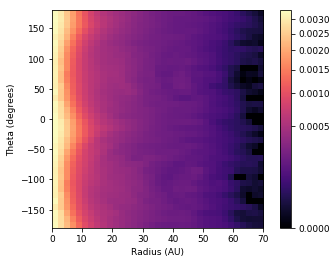

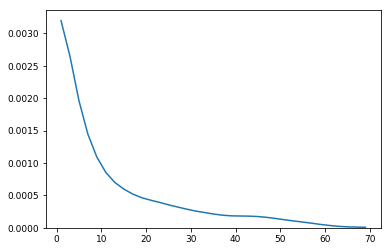

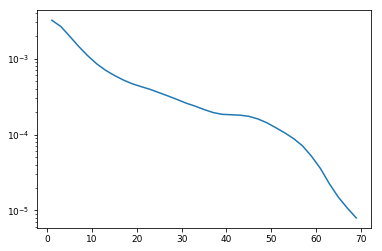

In [2]:


cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
    
radialbins = 1+2*np.arange(35)
surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.2, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=70)
plt.xlim(xmin=0, xmax=70)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.ylim(ymin =0)

plt.show()


plt.semilogy(radialbins, surfbrightness)

plt.show()

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -1.679e-03 arcsec, delta_y = 3.830e-03 arcsec
The MLE semi-major axis is r = 0.280 arcsec
The MLE inclination is i = 21.872 degrees
The MLE position angle is PA = 166.458 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.963e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


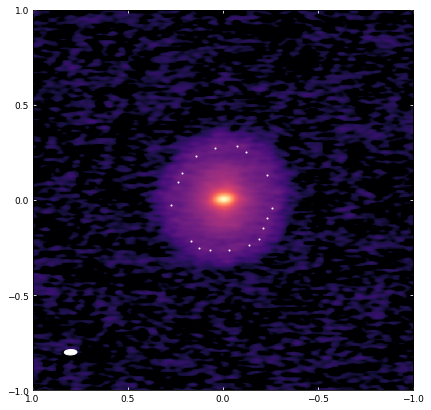

In [3]:


# Extract the ring that's at ~45 AU
xcoords1, ycoords1 = cont.extract_ring(43,50,tbins = -174+12*np.arange(30), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     45/160.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)



In [4]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    #flat priors on x0, y0, r0, logvar
    if not (-4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -15<logvar<-5):
        return -np.inf
    #gaussian prior on PA and cosi based on Andrews+ 2018 (Lupus paper)
    sig_par = .12
    sig_cosi = .013
    return -0.5*((par-2.88)/sig_par)**2-0.5*((cosi-0.93)/sig_cosi)**2

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 30
nthreads = 8
nsteps = 20000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

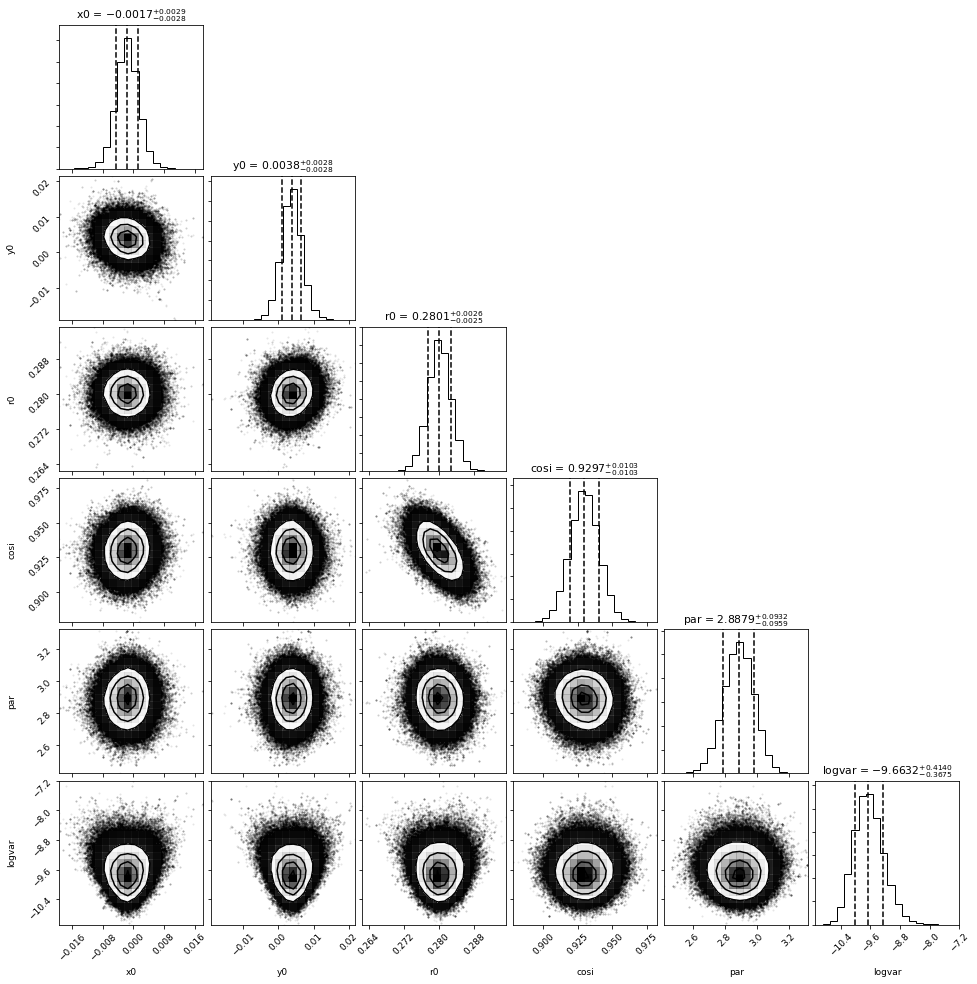

The x offset is delta_x = -1.66e-03 arcsec (+2.9e-03, -2.8e-03)
The y offset is delta_y = 3.78e-03 arcsec (+2.8e-03, -2.8e-03)
The median semi-major axis is r = 0.2801 arcsec (+0.0026, -0.0025) 
or 45.37 AU (+0.45, -0.45)
The incl is i = 21.61 deg (+1.56, -1.67)
The median position angle is PA = 165.46 deg (+5.34, -5.49)
The median log-variance in the pixel offsets from the true ellipse is -9.663e+00


In [7]:


plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)



/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 4.464e-04 arcsec, delta_y = 3.335e-03 arcsec
The MLE semi-major axis is r = 0.236 arcsec
The MLE inclination is i = 17.366 degrees
The MLE position angle is PA = 165.528 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.189e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


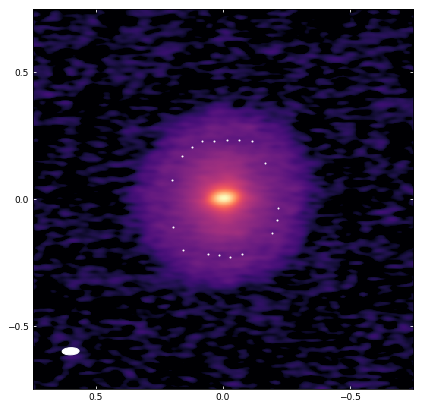

In [8]:


# Extract the gap that's at ~40 AU
xcoords2, ycoords2 = cont.extract_ring(34,42,tbins = -174+12*np.arange(30), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 0.4, 1.5)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     40/160.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2)



In [9]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

In [10]:
np.savez("Sz114ellipsechains.npz", BR45 = sampler1.chain, DA39 = sampler2.chain)

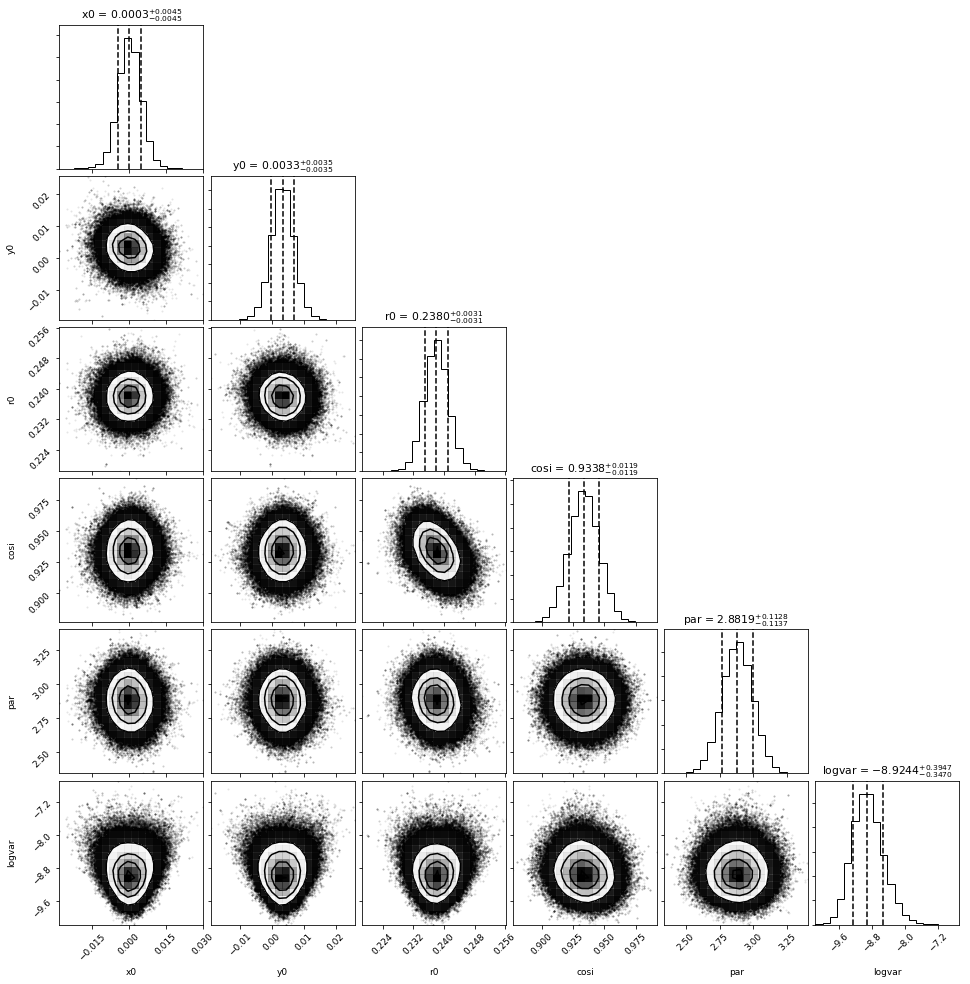

The x offset is delta_x = 2.78e-04 arcsec (+4.5e-03, -4.5e-03)
The y offset is delta_y = 3.26e-03 arcsec (+3.5e-03, -3.5e-03)
The median semi-major axis is r = 0.2380 arcsec (+0.0031, -0.0031) 
or 38.55 AU (+0.57, -0.57)
The incl is i = 20.97 deg (+1.83, -1.99)
The median position angle is PA = 165.12 deg (+6.46, -6.52)
The median log-variance in the pixel offsets from the true ellipse is -8.924e+00


In [11]:
plot_corner(sampler2, 500, 1)
sampler_results(sampler2, 500, cont.src_distance)

In [3]:

maxrad = 70
radialbins = 0.5+np.arange(0, maxrad)
#make some preliminary plots
newcont = Continuum(disk['filename'], -0.0011,.0036, 165.3, 21.3,disk['distance'])
    
_, _, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))
newsurfbrightness, newSB_scatter = newcont.radialprofile(radialbins, high_incl = True)


In [10]:
print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

max [44]
min [38]


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


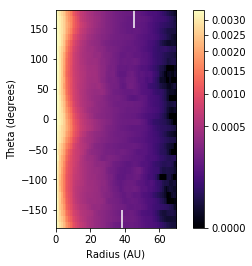

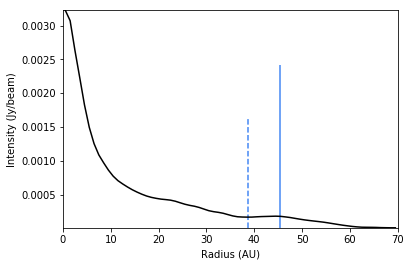

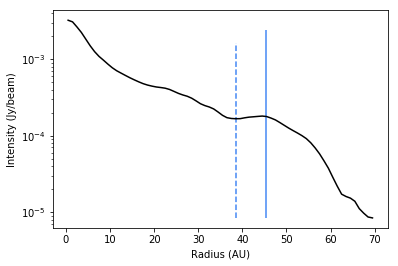

(0, 70)

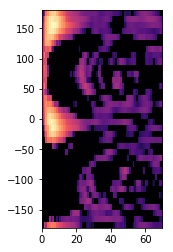

In [5]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
gaps = np.array([38.6])
rings = np.array([45.4])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.mean(newrtmap, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)

In [6]:
measure_widths(38.6,45.4, radialbins, newsurfbrightness, 0, 125)

0.000172176375384 40.8


(4.2999999999999972, 5.3999999999999986)

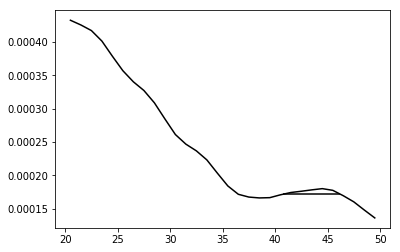

In [11]:
plt.plot(radialbins[20:50], newsurfbrightness[20:50], color = 'black')
#plt.hlines(0.000172176375384, 40.8-4.3,40.8)
plt.hlines(0.000172176375384, 40.8,40.8+5.4)

In [5]:
calc_contrast(38.6,45.4, radialbins, newsurfbrightness, newSB_scatter, newcont, high_incl = True)

(0.93598338704095163, 0.052189903077726127)

57.5


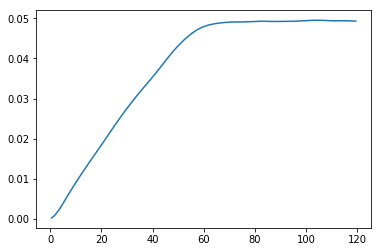

In [8]:
bins = 0.5+1*np.arange(0, 120)

cumeflux = newcont.cumefluxprofile(bins)

plt.plot(bins, cumeflux)
print(bins[np.argmin(np.abs(cumeflux-0.95*np.max(cumeflux)))])